In [141]:
%load_ext autoreload
%autoreload 2
import numpy as np
from juno import utils
from pprint import pprint
from juno.juno_custom.elements.Herschel.structures import HerschelSettings, HerschelSimSettings

from LightPipes import *

from juno.juno_custom.tools import sim_tools
import juno.juno_custom.elements.Herschel.utils as h_utils
import matplotlib.pyplot as plt
from juno.Lens import Lens, LensSettings, LensType
from juno.Medium import Medium

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
config = utils.load_yaml_config(config_filename=r'C:\Users\User\Github\juno\juno\juno_custom\configna488sine.yaml')
settings = HerschelSettings.from_dict(config.get('HerschelSettings'))
sim_settings = HerschelSimSettings.from_dict(config.get('HerschelSimSettings'))
wavelength = sim_settings.wavelength
pixel_size= wavelength * 0.2
# media_wavelength = wavelength / 2
# pixel_size = media_wavelength * 0.5

In [143]:
settings.calculate_radii(pixel_size=pixel_size)
raw_profiles = h_utils.create_raw_profiles(settings)
profiles = h_utils.calculate_profiles(settings, raw_profiles, pixel_size)
lenses = h_utils.generate_lenses(settings, profiles)
padded_lenses = h_utils.calculate_padding(profiles=profiles, lenses=lenses, settings=settings, sim_settings=sim_settings, pixel_size=pixel_size)

In [144]:
sim_lens, sim_lens_padding = sim_tools.generate_sim_lens(settings, sim_settings, pixel_size)
sim_lens.profile = sim_lens.profile.max() - sim_lens.profile
sim_wavefront = sim_tools.generate_sim_wavefront(sim_lens=sim_lens, sim_lens_padding=sim_lens_padding, settings=settings, sim_settings=sim_settings)

In [145]:
start = -settings.z_medium_o * 0.95
stop = -settings.z_medium_o * 1.05
start = -settings.z_medium_o * 0
stop = -settings.z_medium_o * 2
start = -settings.z_medium_o * -1#-1.1
stop = -settings.z_medium_o * 0
# start = -settings.z_medium_o * 0#-1.1
# stop = -settings.z_medium_o * 2

step = (stop-start)/(10-1)
distances = np.arange(start, stop, step)
distances = np.append(distances, stop)
output, propagation, output_array = sim_tools.propagate_zero_lens(wavefront=sim_wavefront, 
                                                settings=settings,
                                                sim_settings=sim_settings, 
                                                distances=distances,
                                                pixel_size=pixel_size)

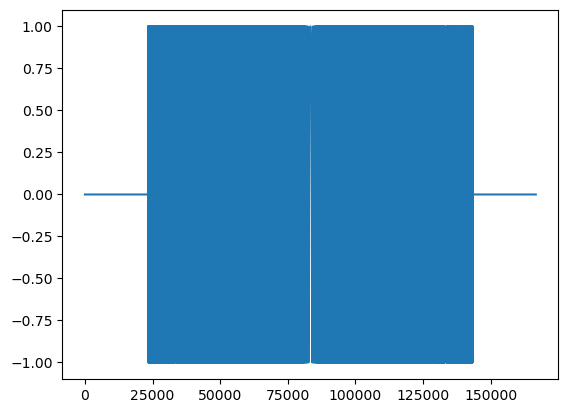

In [146]:
plt.plot(propagation[0])

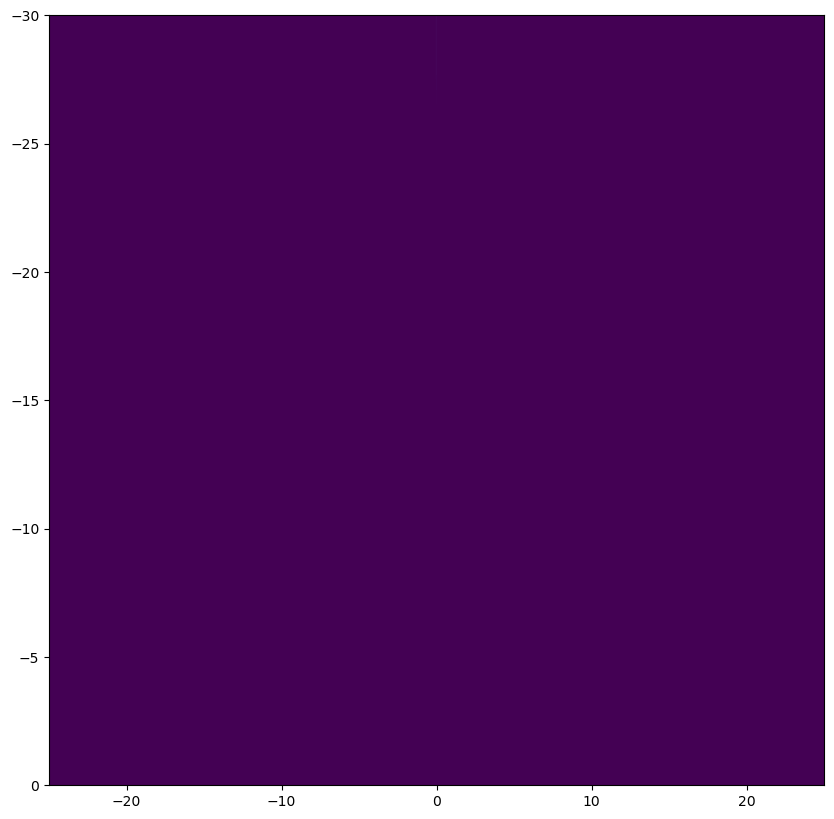

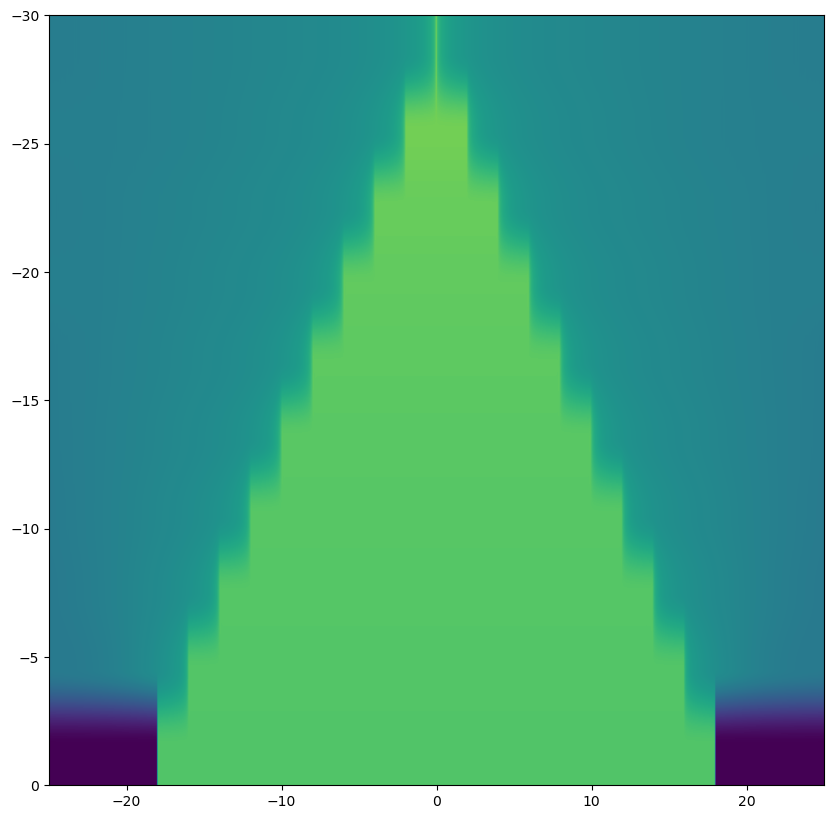

In [147]:
extent = [-output_array.shape[1]*pixel_size/2, output_array.shape[1]*pixel_size/2, distances[-1], distances[0]]

plt.figure(figsize=(10,10))
plt.imshow(output_array, aspect='auto', extent=extent)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(np.log(output_array+1e-12), aspect='auto', extent=extent)
plt.show()

In [148]:
# fdist = -60
# lmed = 1

# lens_settings = LensSettings(
#     diameter=18,
#     height=sim_tools.height_from_focal_distance(diameter=18, lens_medium=lmed, output_medium=2, focal_distance=fdist),
#     exponent=2,
#     medium=lmed,
#     lens_type=LensType.Cylindrical,
#     escape_path=0.,
#     # inverted=True
# )
# lens1 = Lens(diameter=18, height=sim_tools.height_from_focal_distance(diameter=18, lens_medium=lmed, output_medium=2, focal_distance=fdist), exponent=2, medium=Medium(lmed), lens_type=LensType.Cylindrical, settings=lens_settings)

# lens1.generate_profile(pixel_size=pixel_size)

# n = propagation.shape[1]
# pad = (n - lens1.profile.shape[1])//2
# lens1.profile = np.pad(lens1.profile, ((0,0), (pad, pad)), mode='constant', constant_values=0)
# print(lens1.profile.shape)

# print(lens1.profile.shape)

# plt.plot(lens1.profile[0])


In [149]:
def height_from_focal_distance(lens_medium: float, diameter: float,  output_medium: float, focal_distance: float):
    a = 1
    b = -2*focal_distance*(lens_medium-output_medium)/output_medium
    c = (diameter/2)**2

    if (b**2 - 4*a*c < 0):
        raise ValueError("Negative value encountered in sqrt.  Can't find a lens height to give this focal distance")
    else: return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

In [150]:
print(height_from_focal_distance(lens_medium=1, diameter=18, output_medium=2, focal_distance=-30))

3.0


(1, 60001)
(1, 60001)


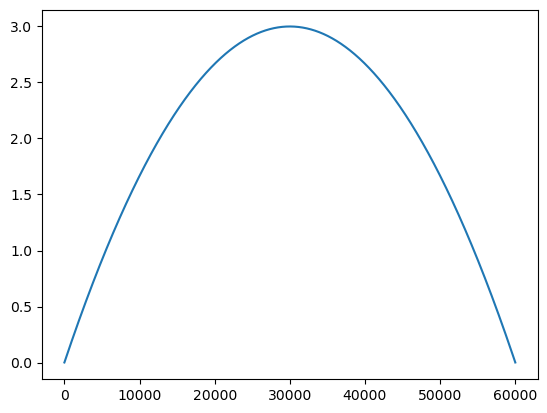

In [151]:
fdist = -30
lens_medium = 1
diam = 18
output_medium = 2
h = 3.0

lens_settings = LensSettings(
    diameter=diam,
    height=h,#sim_tools.height_from_focal_distance(diameter=diam, lens_medium=lens_medium, output_medium=output_medium, focal_distance=fdist),
    exponent=2,
    medium=lens_medium,
    lens_type=LensType.Cylindrical,
    escape_path=0.,
    # inverted=True
)



# lens1 = Lens(diameter=diam, height=sim_tools.height_from_focal_distance(diameter=diam, lens_medium=lens_medium, output_medium=output_medium, focal_distance=fdist), exponent=2, medium=Medium(lens_medium), lens_type=LensType.Cylindrical, )
lens1 = Lens(diameter=diam, height=h, exponent=2, medium=Medium(lens_medium), lens_type=LensType.Cylindrical, )

lens1.generate_profile(pixel_size=pixel_size)

n = propagation.shape[1]
pad = (n - lens1.profile.shape[1])//2
# lens1.profile = np.pad(lens1.profile, ((0,0), (pad, pad)), mode='constant', constant_values=0)
print(lens1.profile.shape)

print(lens1.profile.shape)

plt.plot(lens1.profile[0])

In [152]:
# lens1.profile = -lens1.profile
# plt.plot(lens1.profile[0, :])

In [153]:
delta = sim_tools.delta_map_from_height(lens1.profile, output_medium, lens_medium)
phase = sim_tools.phase_map_from_delta(delta, sim_settings.wavelength)
first_wavefront = sim_tools.wavefront_from_phase(phase, amplitude=1)
first_wavefront = np.pad(first_wavefront, ((0, 0), (pad, pad)), mode='constant', constant_values=0+0j)

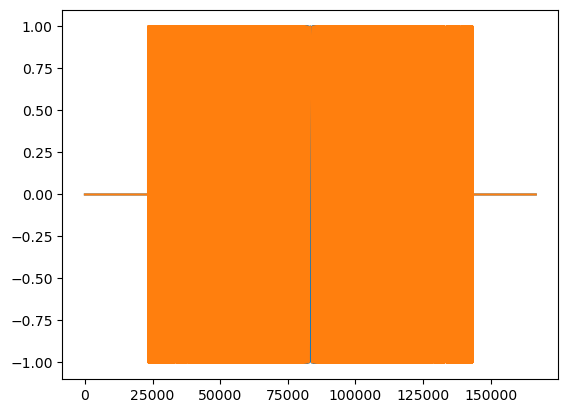

In [154]:
# first_wavefront = sim_tools.generate_lens_first_wavefront(lenses=padded_lenses, settings=settings, sim_settings=sim_settings)
plt.plot(first_wavefront[0])
plt.plot(propagation[0])

In [157]:
start = 0
stop = settings.thickness 
stop = 40
step = (stop-start)/(50-1)
distances = np.arange(start, stop, step)
distances = np.append(distances, stop)

# new_wavefront = first_wavefront * propagation
new_wavefront = first_wavefront# * propagation

output2, propagation2, output_array2 = sim_tools.propagate_first_lens(previous_wavefront=None, wavefront=new_wavefront, settings=settings, distances=distances, sim_settings=sim_settings, pixel_size=pixel_size)


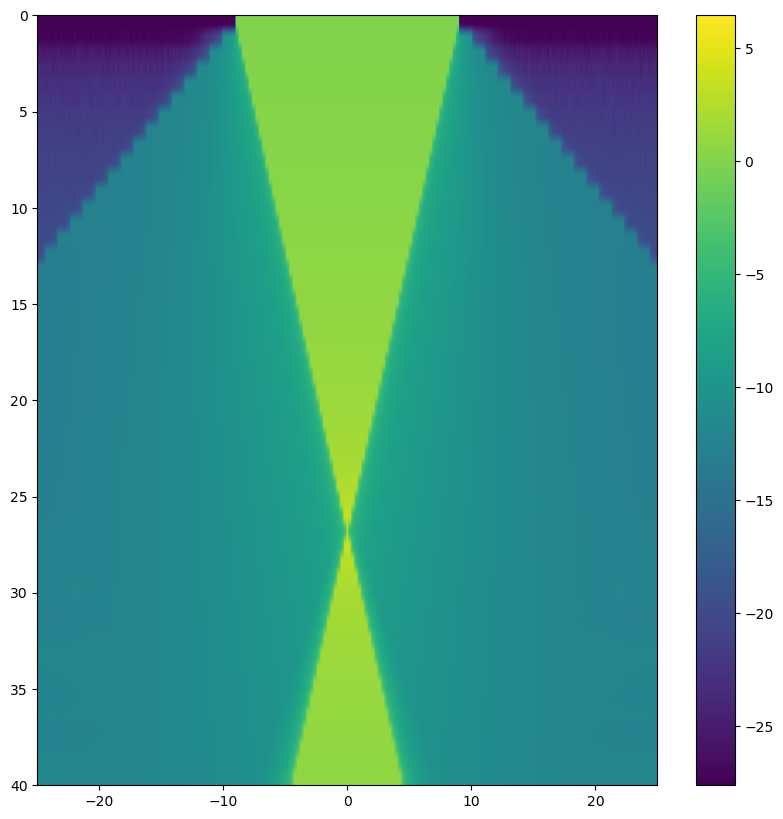

In [158]:
extent = [-output_array2.shape[1]*pixel_size/2, output_array2.shape[1]*pixel_size/2, distances[-1], distances[0]]

# plt.figure(figsize=(10,10))
# plt.imshow(output_array2, aspect='auto', extent=extent)
# plt.colorbar()
# plt.show()
plt.figure(figsize=(10,10))
plt.imshow(np.log(output_array2+1e-12), aspect='auto', extent=extent)
plt.colorbar()
plt.show()


(1, 1819)
(1, 1819)


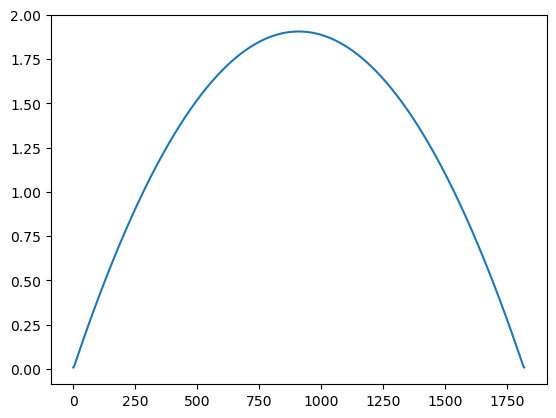

In [219]:
lmed = 2
ldiam = 30
fdist = 60
lens_settings = LensSettings(
    diameter=ldiam,
    height=sim_tools.height_from_focal_distance(diameter=ldiam, lens_medium=lmed, output_medium=1, focal_distance=fdist),
    exponent=2,
    medium=lmed,
    lens_type=LensType.Cylindrical,
    escape_path=0.,
)
lens2 = Lens(diameter=30, height=sim_tools.height_from_focal_distance(diameter=ldiam, lens_medium=lmed, output_medium=1, focal_distance=fdist), exponent=2, medium=Medium(lmed), lens_type=LensType.Cylindrical, settings=lens_settings)

lens2.generate_profile(pixel_size=pixel_size)

print(lens2.profile.shape)
# pad to 6667
# n = 10001
n = propagation.shape[1]
pad = (n - lens2.profile.shape[1])//2
# lens2.profile = np.pad(lens2.profile, ((0, 0), (pad, pad)), mode='constant', constant_values=0)
print(lens2.profile.shape)
plt.plot(lens2.profile[0])

In [220]:
# lens2.profile = -lens2.profile
profile = lens2.profile
delta = sim_tools.delta_map_from_height(lens2.profile, 2, 1)
phase = sim_tools.phase_map_from_delta(delta, sim_settings.wavelength)
wavefront_second = sim_tools.wavefront_from_phase(phase, amplitude=1)
wavefront_second = np.pad(wavefront_second, ((0, 0), (pad, pad)), mode='constant', constant_values=0+0j)

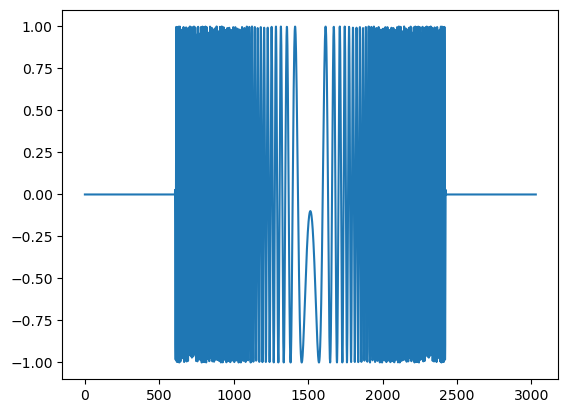

In [221]:
plt.plot(wavefront_second[0])

In [222]:
start = 0
stop = 100
step = (stop-start)/(200-1)
distances = np.arange(start, stop, step)
distances = np.append(distances, stop)

new_wavefront2 = wavefront_second * propagation2

print(f"Step: {step}")
output3, propagation3, output_array3 = sim_tools.propagate_second_lens(previous_wavefront=None, wavefront=new_wavefront2, settings=settings, distances=distances, sim_settings=sim_settings, pixel_size=pixel_size)


Step: 0.5025125628140703


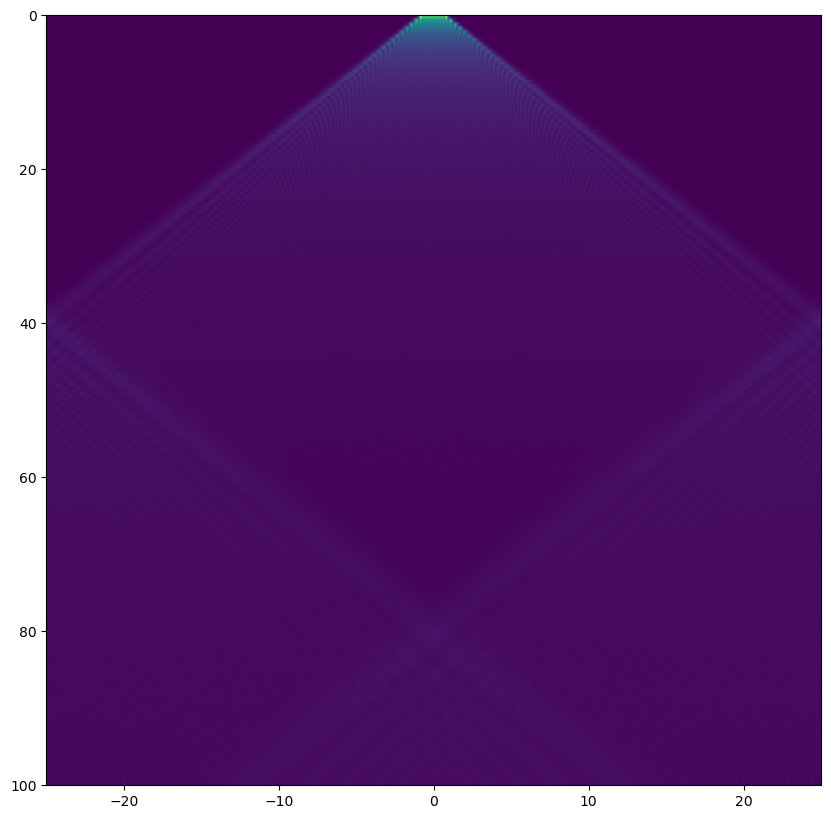

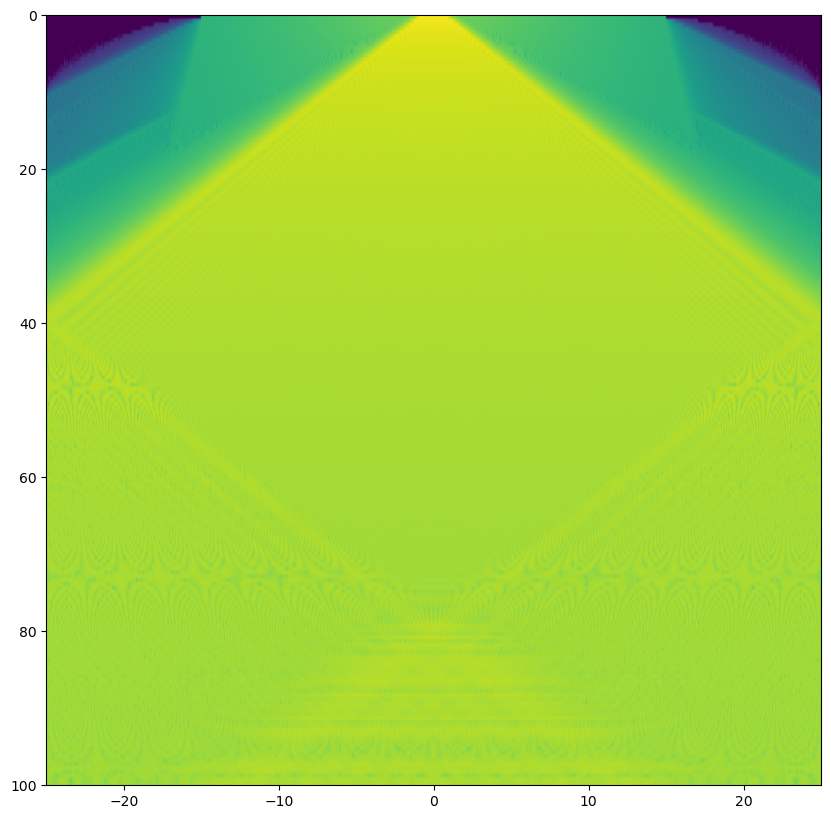

In [223]:
extent = [-output_array3.shape[1]*pixel_size/2, output_array3.shape[1]*pixel_size/2, distances[-1], distances[0]]

plt.figure(figsize=(10,10))
plt.imshow(output_array3, aspect='auto', extent=extent)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(np.log(output_array3+1e-12), aspect='auto', extent=extent)
plt.show()